In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx

c:\Users\zollner\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
data = pd.read_csv('C:/Users/zollner/OneDrive - epfl.ch/Documents/SGR TZ/Quadrant/year=2025/month=10/parsed_16_variables.csv')
data

,day,file_name,device_id,id_type,latitude,longitude,horizontal_accuracy,timestamp,ip_address,device_os,user_agent,country,source_id,publisher_id,geohash,consent,device_manufacturer,device_model
0,day=01,000000_0_5951a46c-07ec-405d-aba4-a045370678bf_...,63216cc1-1f8c-4112-a860-fecf3d4ddc0b,aaid,-3.415847,36.711733,532.0,1759325078000,NaN,Android,NaN,TZ,61,2020,kz6he6htjrun,Y,NaN,NaN
1,day=01,000000_0_5951a46c-07ec-405d-aba4-a045370678bf_...,4f212a79-46f2-4369-87e5-066262bc30cc,aaid,-3.344441,37.345011,433.0,1759334865000,197.186.63.101,Android,NaN,TZ,61,2020,kz6scz1v1z4b,Y,NaN,NaN
2,day=01,000000_0_5951a46c-07ec-405d-aba4-a045370678bf_...,d22c0e22-73f5-4287-a827-02262f6c20eb,aaid,-3.369252,36.582276,3198.0,1759298955000,NaN,Android,Mozilla/5.0 (Linux; Android 10; SM-G960F Build...,TZ,58,1dda65de808c6086b8cc633a6dbd320e,kz6hb6wksvfk,Y,NaN,SM-G960F
3,day=01,000000_0_5951a46c-07ec-405d-aba4-a045370678bf_...,2713cb71-fa3f-4722-86ba-605017ab5886,aaid,-3.370726,36.689256,92.0,1759297694000,NaN,Android,NaN,TZ,61,2020,kz6hffkk1ehj,Y,NaN,NaN
4,day=01,000000_0_5951a46c-07ec-405d-aba4-a045370678bf_...,8DF8275E-E1FB-4EC4-A7D6-582A3F44E6A8,idfa,-3.392585,36.704906,5.6,1759331253000,NaN,iOS,NaN,TZ,58,8826dbc0dba06d52a75807525d5ff255,kz6henrsy23d,Y,NaN,iPhone12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6821372,day=07,000004_0_66692715-5849-4e42-ab90-b02aeb886104_...,0751b78a-6e58-4fbe-a6d0-c1fa7c162bf1,aaid,-6.864424,39.226354,548.0,1759872112000,NaN,Android,NaN,TZ,61,2020,kygbuw7gb69e,Y,NaN,NaN
6821373,day=07,000004_0_66692715-5849-4e42-ab90-b02aeb886104_...,eb10226d-bb2d-44bf-a626-b17b451763bf,aaid,-6.709915,39.229544,7.0,1759844097000,NaN,Android,NaN,TZ,58,f7cceb4540d611ea2d200e6b4470652a,kygcudqpfthr,Y,NaN,SM-G970F
6821374,day=07,000004_0_66692715-5849-4e42-ab90-b02aeb886104_...,46af1ee8-c431-4b77-a73e-a5e122d73a3a,aaid,-6.791860,39.147069,898.0,1759878615000,NaN,Android,Mozilla/5.0 (Linux; Android 9; Infinix X650B B...,TZ,58,aa1e4eeb7d6264d1babb1ffaffadaa66,kygc6gd48cd4,Y,NaN,Infinix X650B
6821375,day=07,000004_0_66692715-5849-4e42-ab90-b02aeb886104_...,030afed9-2088-4403-8a95-54744329ebd4,aaid,-6.710000,39.110000,1105.0,1759866846000,41.222.177.246,Android,NaN,TZ,58,9922,kygccfrp3j3d,Y,NaN,NaN


Edit data

In [3]:
import pandas as pd
import numpy as np

def convert_epoch_to_datetime(series, to_timezone='Africa/Dar_es_Salaam'):
    """
    Convert numeric or string epoch timestamps (seconds or milliseconds)
    to pandas datetimes in Tanzania local time.
    """
    s = pd.to_numeric(series, errors='coerce')
    
    # Detect seconds vs milliseconds
    if s.mean() > 1e12:
        unit = 'ms'
    else:
        unit = 's'

    # Convert to UTC first, then to local timezone
    dt = pd.to_datetime(s, unit=unit, utc=True)
    if to_timezone:
        dt = dt.dt.tz_convert(to_timezone)
    return dt

# ---- Usage example ----
data['timestamp'] = convert_epoch_to_datetime(data['timestamp'])
print(data['timestamp'].head())
print(data['timestamp'].dtype)


0   2025-10-01 16:24:38+03:00
1   2025-10-01 19:07:45+03:00
2   2025-10-01 09:09:15+03:00
3   2025-10-01 08:48:14+03:00
4   2025-10-01 18:07:33+03:00
Name: timestamp, dtype: datetime64[ns, Africa/Dar_es_Salaam]
datetime64[ns, Africa/Dar_es_Salaam]


# Identifying home location

In [4]:
# Define "overnight" as 7 PM to 7 AM
data['hour'] = data['timestamp'].dt.hour
data['date'] = data['timestamp'].dt.date
data['overnight'] = data['hour'].ge(19) | data['hour'].lt(7)

#  Map overnight points to "night date"
# Observations after midnight count toward the previous night
gps_overnight = data[data['overnight']].copy()
gps_overnight['night_date'] = gps_overnight['timestamp'].dt.date
gps_overnight.loc[gps_overnight['hour'] < 6, 'night_date'] = (
    gps_overnight.loc[gps_overnight['hour'] < 6, 'night_date'] - pd.to_timedelta(1, unit='d')
)


# Round lat/lon to reduce precision (such that we do not get too many different home locations)
gps_overnight['latitude'] = gps_overnight['latitude'].round(3)
gps_overnight['longitude'] = gps_overnight['longitude'].round(3)

# Define individual home location as the most frequent location during overnight hours
home_locations = (
    gps_overnight
    .groupby(['device_id', 'latitude', 'longitude'])
    .size()
    .reset_index(name='counts')
)

# Rename lat/lon columns for merging
home_locations = home_locations.rename(columns={'latitude': 'home_latitude', 'longitude': 'home_longitude'})

# Get the most frequent location per device_id and night_date
home_locations = (
    home_locations
    .sort_values(['device_id', 'counts'], ascending=[True, False])
    .drop_duplicates(subset=['device_id'], keep='first') # if all locations are equally frequent, take a random one
    .reset_index(drop=True)
)



There is one device that has 22420 pings recorded across the week. 

In [9]:
# How many users are only seen once at their chosen home location?

home_locations['counts'].value_counts() # 31 134 users are only seen once at their home location


counts
1      31134
2      19395
3      10016
4       8015
5       5403
       ...  
466        1
578        1
596        1
881        1
572        1
Name: count, Length: 549, dtype: int64

In [5]:
# Merge home locations back to original data
data = data.merge(
    home_locations[['device_id', 'home_latitude', 'home_longitude']],
    left_on=['device_id'],
    right_on=['device_id'],
    how='left'
)

# Plotting home locations

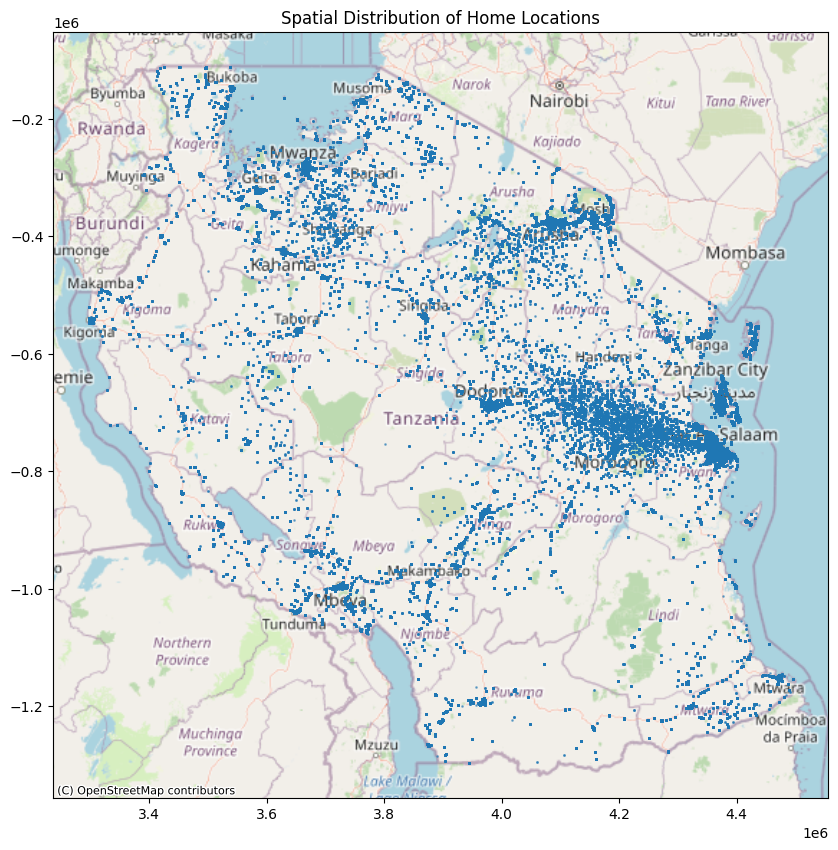

In [6]:
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.home_longitude, data.home_latitude), crs="EPSG:4326")
subset = gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 10))
subset.plot(ax=ax, markersize=1, alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Spatial Distribution of Home Locations')
plt.show()

# Plotting OD flows

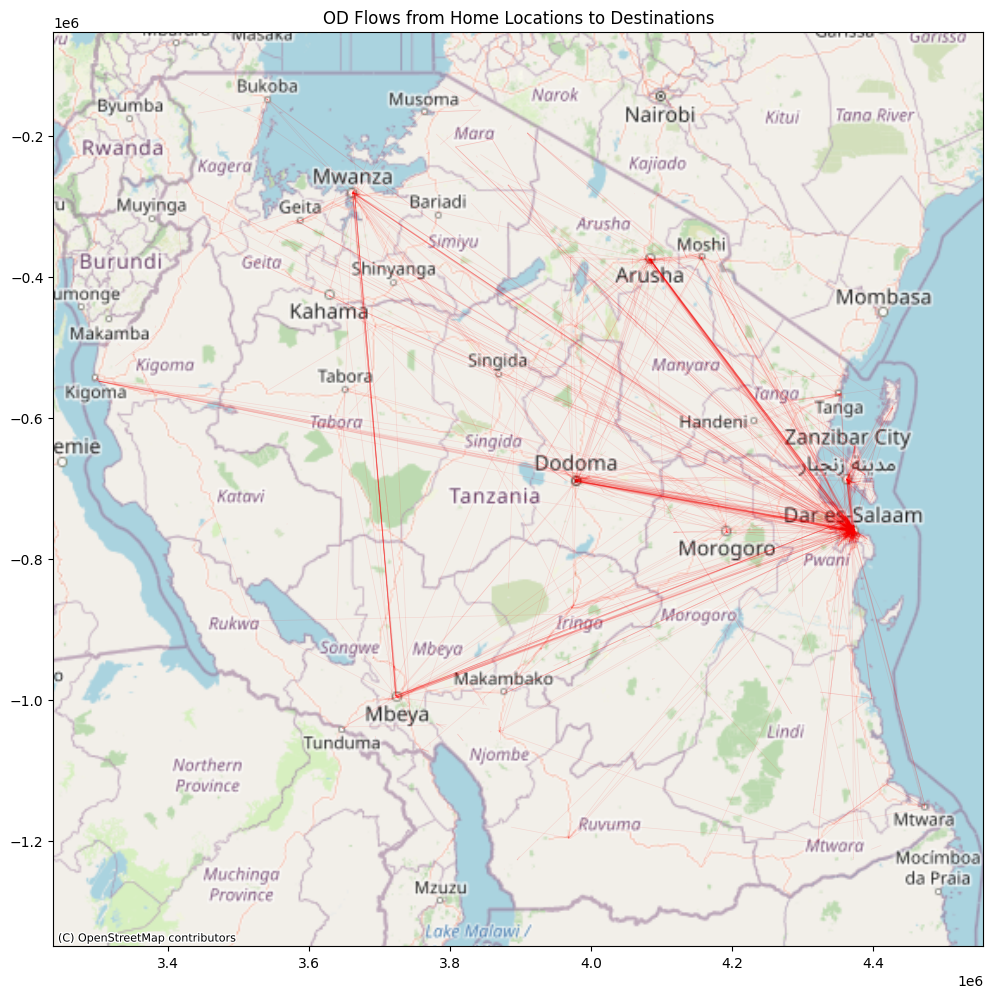

In [8]:
from shapely.geometry import LineString

# Filter data to only include records with valid home locations
od_data = data[data['home_latitude'].notna() & data['home_longitude'].notna()].copy()

# Create origin and destination geometry
od_gdf = gpd.GeoDataFrame(
    od_data,
    geometry=gpd.points_from_xy(od_data.longitude, od_data.latitude),
    crs="EPSG:4326"
)

# Create line geometries from home to destination

od_gdf['origin'] = gpd.points_from_xy(od_data.home_longitude, od_data.home_latitude)
od_gdf['od_line'] = od_gdf.apply(
    lambda row: LineString([row['origin'], row['geometry']]) 
    if row['home_latitude'] != row['latitude'] or row['home_longitude'] != row['longitude']
    else None, 
    axis=1
)

# Filter out None values (same origin and destination)
od_lines = od_gdf[od_gdf['od_line'].notna()].copy()
od_lines = od_lines.set_geometry('od_line')
od_lines = od_lines.set_crs(epsg=4326)

# Project to Web Mercator for visualization
od_lines_proj = od_lines.to_crs(epsg=3857)

# Sample the data for better visualization (optional)
od_sample = od_lines_proj.sample(min(10000, len(od_lines_proj)))

# Plot
fig, ax = plt.subplots(figsize=(12, 12))
od_sample.plot(ax=ax, linewidth=0.5, alpha=0.1, color='red')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('OD Flows from Home Locations to Destinations')
plt.show()

